In [1]:
%pip install opencv-python
%pip install scikit-learn
%pip install tensorflow
%pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\srika\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



                                              0.0/38.1 MB ? eta -:--:--
                                             0.0/38.1 MB 960.0 kB/s eta 0:00:40
                                              0.1/38.1 MB 1.3 MB/s eta 0:00:29
                                              0.2/38.1 MB 1.3 MB/s eta 0:00:29
                                              0.4/38.1 MB 2.0 MB/s eta 0:00:19
                                              0.7/38.1 MB 2.9 MB/s eta 0:00:13
     -                                        1.0/38.1 MB 3.4 MB/s eta 0:00:11
     -                                        1.3/38.1 MB 3.8 MB/s eta 0:00:10
     -                                        1.6/38.1 MB 4.2 MB/s eta 0:00:09
     -                                        1.9/38.1 MB 4.5 MB/s eta 0:00:09
     --                                       2.1/38.1 MB 4.4 MB/s eta 0:00:09
     --                                       2.4/38.1 MB 4.6 MB/s eta 0:00:08
     --                                       2.7/38.1 MB


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\srika\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



                                              0.0/9.2 MB ? eta -:--:--
                                              0.1/9.2 MB 1.1 MB/s eta 0:00:09
                                              0.1/9.2 MB 1.2 MB/s eta 0:00:08
                                              0.2/9.2 MB 1.5 MB/s eta 0:00:06
     -                                        0.5/9.2 MB 2.3 MB/s eta 0:00:04
     ---                                      0.7/9.2 MB 3.0 MB/s eta 0:00:03
     ----                                     1.0/9.2 MB 3.3 MB/s eta 0:00:03
     -----                                    1.2/9.2 MB 3.6 MB/s eta 0:00:03
     ------                                   1.5/9.2 MB 4.0 MB/s eta 0:00:02
     -------                                  1.8/9.2 MB 4.2 MB/s eta 0:00:02
     --------                                 2.0/9.2 MB 4.3 MB/s eta 0:00:02
     ----------                               2.3/9.2 MB 4.4 MB/s eta 0:00:02
     -----------                              2.6/9.2 MB 4.6 MB/s eta 


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\srika\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



                                              0.0/7.5 MB ? eta -:--:--
                                              0.0/7.5 MB 1.3 MB/s eta 0:00:06
                                              0.1/7.5 MB 1.3 MB/s eta 0:00:06
                                              0.2/7.5 MB 1.4 MB/s eta 0:00:06
     -                                        0.3/7.5 MB 1.6 MB/s eta 0:00:05
     --                                       0.5/7.5 MB 2.3 MB/s eta 0:00:03
     ----                                     0.8/7.5 MB 3.0 MB/s eta 0:00:03
     -----                                    1.1/7.5 MB 3.4 MB/s eta 0:00:02
     -------                                  1.4/7.5 MB 3.7 MB/s eta 0:00:02
     ---------                                1.7/7.5 MB 4.0 MB/s eta 0:00:02
     ----------                               1.9/7.5 MB 4.0 MB/s eta 0:00:02
     -----------                              2.2/7.5 MB 4.3 MB/s eta 0:00:02
     --------------                           2.6/7.5 MB 4.5 MB/s eta 


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\srika\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow Version", tf.__version__)


Tensorflow Version 2.13.0


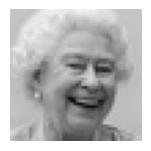

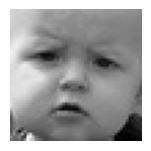

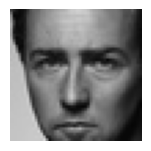

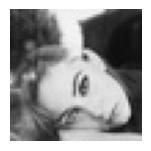

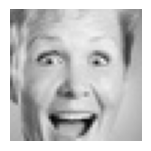

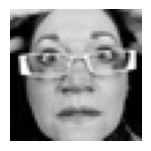

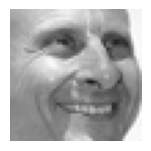

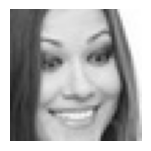

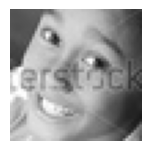

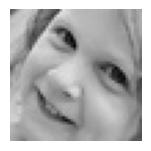

In [3]:
images  = glob("train/**/**")
for i in range(10):
  image = random.choice(images)
  plt.figure(figsize=(12,12))
  plt.subplot(6, 2, 1)
  plt.imshow(cv2.imread(image));plt.axis('off')

In [4]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/", target_size = (img_size, img_size),color_mode = "grayscale",batch_size = batch_size, class_mode = "categorical", shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/", target_size = (img_size, img_size),color_mode = "grayscale",batch_size = batch_size, class_mode = "categorical", shuffle = True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
def Convolution(input_tensor, filters, kernel_size):
  x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)

  return x

In [6]:
def Dense_f(input_tensor, nodes):
  x = Dense(nodes)(input_tensor)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)

  return x

In [7]:
def model_fer(input_shape):
  inputs = Input(input_shape)
  conv_1 = Convolution(inputs, 32,(3,3))
  conv_2 = Convolution(inputs, 64,(5,5))
  conv_3 = Convolution(inputs, 128,(3,3))

  flatten = Flatten()(conv_3)
  dense_1 = Dense_f(flatten, 256)

  output = Dense(7, activation = "softmax")(dense_1)
  model = Model(inputs = [inputs], outputs = [output])

  model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

  return model

In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 128)       0         
                                                                 
 flatten (Flatten)           (None, 73728)             0     

In [10]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weight.h5", monitor = 'val_accuracy', save_weight_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

In [11]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
  callbacks = callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6917 - accuracy: 0.3603
Epoch 1: saving model to model_weight.h5


C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 1189s 3s/step - loss: 1.6917 - accuracy: 0.3603 - val_loss: 1.5664 - val_accuracy: 0.4103
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3994 - accuracy: 0.4704
Epoch 2: saving model to model_weight.h5
448/448 [==============================] - 895s 2s/step - loss: 1.3994 - accuracy: 0.4704 - val_loss: 1.6989 - val_accuracy: 0.3990
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2357 - accuracy: 0.5336
Epoch 3: saving model to model_weight.h5
448/448 [==============================] - 775s 2s/step - loss: 1.2357 - accuracy: 0.5336 - val_loss: 1.5195 - val_accuracy: 0.4302
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.1053 - accuracy: 0.5897
Epoch 4: saving model to model_weight.h5
448/448 [==============================] - 820s 2s/step - loss: 1.1053 - accuracy: 0.5897 - val_loss: 1.4543 - val_accuracy: 0.4616
Epoch 5/15
448/448 [==============================] - ETA: 0

In [12]:
model.evaluate(validation_generator)

113/113 [==============================] - 22s 191ms/step - loss: 2.0177 - accuracy: 0.4850


[2.0177266597747803, 0.48495402932167053]

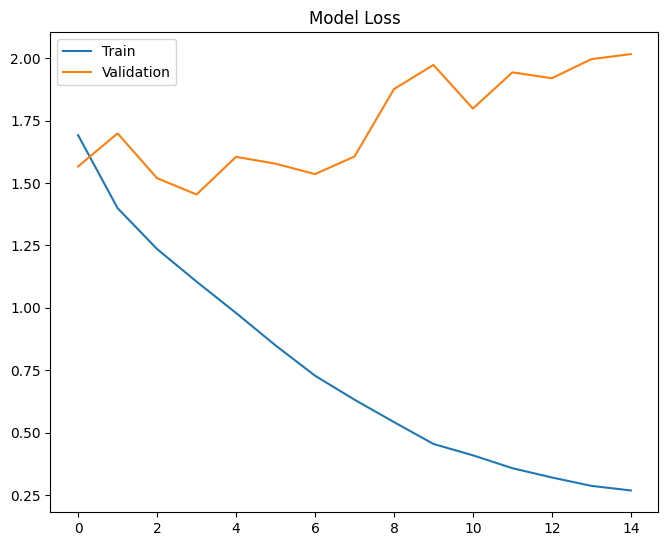

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0,right=0.95, left=0.0, hspace=0.25, wspace=0.35)

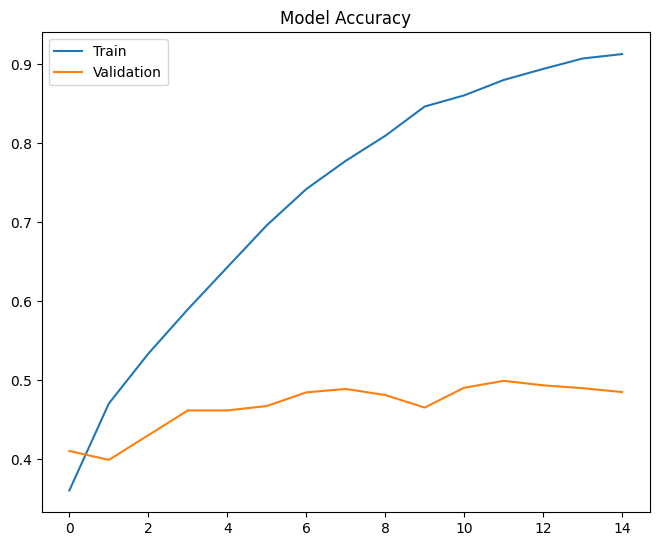

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0,right=0.95, left=0.0, hspace=0.25, wspace=0.35)

In [27]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)